In [1]:
import os
from datetime import datetime
import datetime as dt
from queue import Queue
import json
import requests
import pandas as pd
import time

from apscheduler.schedulers.background import BackgroundScheduler
from aws.src.TransGPSCVMonitor import TransGPSCVMonitor
from PTETA.listener.utils.support_classes import LockingCounter


from matplotlib import pyplot as plt
import numpy as np

In [20]:
REQUEST_URI = 'https://gt.kh.ua/?do=api&fn=gt&noroutes'
DATETIME_PATTERN = '%Y-%m-%d %H:%M:%S'

REQUEST_FREQUENCY = 5
PROCESS_FREQUENCY = 60

START_DATE = datetime.now().strftime(DATETIME_PATTERN)
END_DATE = (datetime.now() + dt.timedelta(days=30)).strftime(DATETIME_PATTERN)
END_DATE_2 = (datetime.now() + dt.timedelta(days=30, seconds=2 * PROCESS_FREQUENCY)).strftime(DATETIME_PATTERN)
COLUMNS = [
    'imei', 'lat', 'lng', 'speed', 'gps_datetime_origin', 'orientation',
    'route_name', 'route_type', 'vehicle_id', 'dd', 'gpstime', 'response_datetime'
]


def request_data(process_queue: Queue, request_counter: LockingCounter) -> None:
    dt_now = datetime.now()
    dt_tz_str = dt.datetime.now(dt.timezone.utc).strftime(f"{DATETIME_PATTERN} %z")

    try:
        request = requests.get(REQUEST_URI)
        if (request is None) or (request.text is None):
            return
        response = json.loads(request.text)
        response['response_datetime'] = dt_tz_str

        try:
            process_queue.put(response, timeout=5)
        except process_queue.Full as e:
            print(f"{dt_now.strftime(DATETIME_PATTERN)}\n"
                  f"\tQueue is full, its' size is {process_queue.qsize()}"
                  f"\t{e}\n")
            raise e
        request_counter.increment()

    except (requests.Timeout, requests.ConnectionError, requests.HTTPError) as err:
        print(f"{dt_now.strftime(DATETIME_PATTERN)} : error while trying to GET data\n"
              f"\t{err}\n")

In [32]:
from tqdm import trange

In [78]:
request_queue = Queue(maxsize=100_000)
request_counter = LockingCounter()
request_counter.set_is_shown(True)


for _ in trange(120):
    request_data(request_queue, request_counter)
    time.sleep(1)

100%|██████████| 120/120 [02:15<00:00,  1.13s/it]


In [35]:
from copy import deepcopy

In [79]:
request_queue_cp = Queue()
request_queue2 = Queue()

def copy_data(src, dst1, dst2):
    while not src.empty():
        obj = src.get()
        dst1.put(obj)
        dst2.put(obj)
        
print(request_queue.qsize(), request_queue_cp.qsize(), request_queue2.qsize())
copy_data(request_queue, request_queue_cp, request_queue2)
print(request_queue.qsize(), request_queue_cp.qsize(), request_queue2.qsize())

120 0 0
0 120 120


In [101]:
print(request_queue.qsize(), request_queue_cp.qsize(), request_queue2.qsize())
copy_data(request_queue, request_queue_cp, request_queue2)
# copy_data(request_queue2, request_queue_cp, request_queue)
print(request_queue.qsize(), request_queue_cp.qsize(), request_queue2.qsize())

120 0 0
0 120 120


In [102]:
def clear_data(in_df, verbose: bool = False):
    unique_data = []

    in_df["gpstime_ns"] = pd.to_datetime(df_["gpstime"])
    imei_list = in_df['imei'].value_counts().index

    for imei in imei_list:
        row_data = in_df[in_df['imei'] == imei].values.tolist()
        row_data = sorted(row_data, key=lambda x : x[-1])
        result = [row_data[0][:-1]]
        for row0, row1 in zip(row_data[:-1], row_data[1:]):
            if row0[1:9] != row1[1:9]:
                result += [row1[:-1]]
        unique_data += result
        
    del in_df['gpstime_ns']

    df_unique = pd.DataFrame(unique_data, columns=in_df.columns)
    if verbose:
        print(f"Clear data\n\t{len(in_df)} / {len(df_unique)} [avg {len(in_df) / len(df_unique):.02f}]")
    return df_unique

def process_data(
        request_queue: Queue,
        last_avl_df_queue: Queue,
#         monitor: TransGPSCVMonitor,
#         records_counter: LockingCounter,
        verbose: bool = False
) -> None:
    if verbose:
        print(f"process_data::{datetime.now().strftime(DATETIME_PATTERN)} : "
              f"Queue len is {request_queue.qsize()}")
    avl_data_list = []
    while not request_queue.empty():
        response = request_queue.get()
        avl_data_list += [
            row + [response['timestamp'], response['response_datetime']]
            for row in response['rows']
        ]

    if not avl_data_list:
        return

    df = pd.DataFrame(avl_data_list, columns=COLUMNS)

    if last_avl_df_queue.empty():
        pass
    else:
        last_avl_df = last_avl_df_queue.get()
        while not last_avl_df_queue.empty():
            last_avl_df_queue.get()
        
        df = pd.concat([df, last_avl_df])
        
    df_u = clear_data(df)
            
    if verbose:
        print(f"\tprocess_data:: unique {len(df_u)} of {df}")
        
    last_avl_list = list()
    for state, frame in df_u.groupby('imei'):
        item = frame.sort_values(
            by="gpstime", ascending=False, key=lambda x: x.astype('datetime64[ns]')
        ).iloc[0]
        last_avl_list.append(item)

    last_avl_df = pd.DataFrame(last_avl_list, columns=df_u.columns)
    last_avl_df_queue.put(last_avl_df)
    if verbose:
        print(f"\tprocess_data:: New last awl {len(last_avl_df)} was {len(last_avl_list)}")

    if len(df_to_write) > 0:
        monitor.write_to_db(df_to_write.to_dict('records'))
        records_counter.increment(len(df_to_write))
    return df_u

    if verbose:
        print(f"\tprocess_data:: to write {len(df_to_write)} of unique {len(df)}")

In [103]:
last_avl_df_queue = Queue()
df_unq = process_data(request_queue_cp, last_avl_df_queue)

Clear data
	26760 / 748 [avg 35.78]


In [104]:
df_q = last_avl_df_queue.get()

In [119]:
import seaborn as sns

<AxesSubplot:xlabel='gpstime', ylabel='Count'>

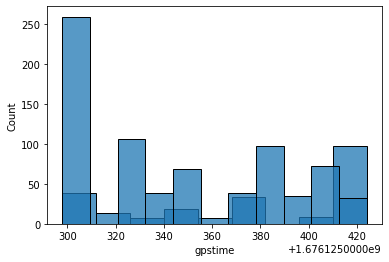

In [120]:
sns.histplot(pd.to_datetime(df_q["gpstime"]).astype(int)//10**9)
sns.histplot(pd.to_datetime(df_unq["gpstime"]).astype(int)//10**9)

In [136]:
freq = []

for i, (state, frame) in enumerate(df_unq.groupby('imei')):
    tm_np = (pd.to_datetime(frame["gpstime"]).astype(int)//10**9).values
    freq += np.diff(tm_np).tolist()
    print(f"{i:03d} - {state}) {len(frame)} {np.diff(tm_np)}")

000 - 350544500100667) 1 []
001 - 350544502364030) 4 [ 8 61 13]
002 - 350544502364287) 6 [36 33 13 16 28]
003 - 352094086897037) 5 [ 8 16 12 33]
004 - 352094088222846) 5 [24 29 29 30]
005 - 352625690655665) 1 []
006 - 352625692263401) 5 [24 29 29 30]
007 - 352625692435918) 5 [24 29 29 30]
008 - 352625693425165) 3 [53 59]
009 - 352625695995033) 4 [53 29 30]
010 - 352625696031960) 1 []
011 - 352625696130515) 5 [24 29 29 30]
012 - 352625696555422) 2 [24]
013 - 352625696558749) 6 [ 8 74 16 14 14]
014 - 352625696567443) 8 [ 8 16 12 33 13 16 28]
015 - 352625696572211) 6 [36 33 13 16 28]
016 - 352625696574555) 5 [ 8 61 13 30]
017 - 352625696575313) 8 [ 8 16 12 33 13 16 28]
018 - 352625696582574) 7 [ 8 28 33 13 16 28]
019 - 352625696582582) 7 [ 8 16 12 33 13 16]
020 - 352625696582657) 5 [24 12 33 13]
021 - 352625696583044) 5 [24 45 13 16]
022 - 352625696605235) 5 [ 8 16 74 28]
023 - 352625696610979) 3 [69 13]
024 - 352625696974680) 1 []
025 - 352625697294195) 1 []
026 - 352625697708343) 1 []
0

In [140]:
min(freq), max(freq)

(8, 126)

<AxesSubplot:ylabel='Count'>

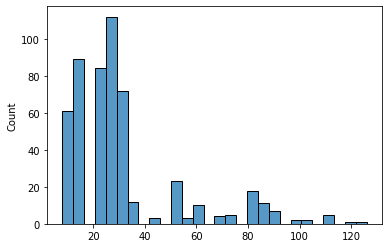

In [139]:
sns.histplot(freq)


In [85]:
df_u = clear_data(df_)

Clear data
	26760 / 748 [avg 35.78]


In [62]:
data_row = [row + [resp['timestamp'], resp['response_datetime']] 
            for row in resp['rows']]
df = pd.DataFrame(data_row, columns=COLUMNS)

In [63]:
df

,imei,lat,lng,speed,gps_datetime_origin,orientation,route_name,route_type,vehicle_id,dd,gpstime,response_datetime
0,352094086897037,273731,944340,29,0,101,1,2,2621,13,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
1,352625696582582,260170,948132,36,0,182,304,2,2742,16,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
2,353976013861061,337570,945370,6,0,265,3,2,2647,16,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
3,352625699912554,409359,919060,18,0,28,51,2,2746,17,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
4,352625699914634,307770,944191,34,0,86,1,2,2620,17,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
...,...,...,...,...,...,...,...,...,...,...,...,...
220,353976014321370,195469,1042480,24,0,342,20,1,3042,136,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
221,353976013846088,302670,954922,39,0,14,35,2,2633,145,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
222,354330030964533,359291,991058,0,0,0,8,1,3019,149,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000
223,354330030918687,313820,945210,21,0,357,1,2,2102,250,2023-02-11T13:18:49+00:00,2023-02-11 13:18:57 +0000


In [2]:
CONNECTION_CONFIG = dict({
        'host': os.environ['RDS_HOSTNAME'],
        'database': "pteta_db",
        'user': "postgres",
        'password': os.environ['RDS_PTETA_DB_PASSWORD']
    })

In [3]:
monitor = TransGPSCVMonitor(CONNECTION_CONFIG, data_model="kharkiv")

In [6]:
from PTETA.utils.transport.kharkiv.KharkivTransportVehicle import KharkivTransportVehicle

In [10]:
tv = KharkivTransportVehicle(id=None, imei='354330030949633', name='NULL', owner_id=-1)

In [11]:
monitor.vehicle_to_id[tv]

659

In [12]:
from PTETA.utils.transport.kharkiv.KharkivTransportRoute import KharkivTransportRoute

In [13]:
tr = KharkivTransportRoute(id=None, name='45', type=3)

In [15]:
monitor.route_to_id[tr]

86